In [7]:
import win32com.client
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [8]:
def camera_init():
    try:
        # Launch ASCOM chooser
        chooser = win32com.client.Dispatch("ASCOM.Utilities.Chooser")
        chooser.DeviceType = "Camera"  # Can be 'Telescope', 'Camera', 'FilterWheel', etc.

        # Pick ZWO ASCOM driver (GUI opens)
        camera_id = chooser.Choose(None)

        print("You selected:", camera_id)
    except:
        print("No camera detected")

In [9]:
camera_init()

No camera detected


In [4]:
def take_ramp(cam_name, exp_low, exp_high, num_exp=10, num_frames=1, img_shape=(1000,1000),
              save_path=None, bit_depth=16, temp_setpoint=None):
    '''Record images with logarithmically spaced exposure times
    ---------------
    Parameters:
    cam_name : object
        Name of the camera object, typically obtained from ASCOM chooser.
    exp_low : float
        Minimum exposure time in seconds.
    exp_high : float
        Maximum exposure time in seconds.
    num_exp : int
        Number of exposure times to record.
    num_frames : int
        Number of frames to record at each exposure time.
    img_shape : tuple
        Shape of the images to be recorded (height, width).
    save_path : str
        Path to save the recorded images. If None, images are not saved.
    ---------------
    Returns:
    img_array : numpy.ndarray
        Array of recorded images with shape (num_exp, num_frames, height, width).
    '''
    exp_times = np.logspace(np.log10(exp_low), np.log10(exp_high), num_exp)
    if bit_depth in [10, 12, 14, 16]:
        img_array = np.zeros((num_exp, num_frames, *img_shape), dtype=np.uint16)
    elif bit_depth == 8:
        img_array = np.zeros((num_exp, num_frames, *img_shape), dtype=np.uint8)
    else:
        raise ValueError("Unsupported bit depth. Choose from [8, 10, 12, 14, 16].")
    img_times = np.zeros((num_exp, num_frames))
    # Connect to camera
    camera = win32com.client.Dispatch(cam_name)
    camera.Connected = True
    # Set subarray to take
    cam_width = camera.CameraXSize
    cam_height = camera.CameraYSize
    # Add loop to set camera temperature and wait for it to stabilize
    cam_temp = camera.CCDTemperature
    print(f"Camera connected: {cam_name}, Size: {cam_width}x{cam_height}, Temperature: {cam_temp:.2f}C")
    # Setup camera for exposure
    camera.BinX = 1
    camera.BinY = 1
    camera.NumX = img_shape[1]
    camera.NumY = img_shape[0]
    camera.StartX = (cam_width - img_shape[1]) // 2
    camera.StartY = (cam_height - img_shape[0]) // 2
    for i, exp_time in enumerate(exp_times):
        print(f"Taking frames at {exp_time:.8f} seconds (exposure time {i+1}/{num_exp})")
        for j in range(num_frames):
            # print(exp_time)
            camera.StartExposure(exp_time, False)
            # ZZZ need to figure out how to get actual exposure time from camera
            # (will get rounded slightly by camera firmware)
            while not camera.ImageReady:
                time.sleep(0.1)
            img = camera.ImageArray
            img_array[i, j] = np.array(img)
            img_times[i, j] = time.time()
    
        # saves images to 'save_path'
        if save_path is not None:
            img_array3d = img_array[0, :, :, :]
            hdu = fits.PrimaryHDU(img_array3d)
            hdr = hdu.header
            hdr['DATE'] = time.strftime('%Y-%m-%dT%H:%M:%S', time.gmtime())
            hdr.comments['DATE'] = 'File creation date'
            # hdr['DATE-OBS'] = camera.LastExposureStartTime
            # hdr.comments['DATE-OBS'] = 'Date of data acquisition'
            # hdr['EXPTIME'] = camera.LastExposureDuration
            hdr['EXPTIME'] = round(exp_time/camera.ExposureResolution)*camera.ExposureResolution
            hdr.comments['EXPTIME'] = 'Exposure time in s'
            hdr['TEMP'] = camera.CCDTemperature
            hdr.comments['TEMP'] = 'Sensor temperature (in deg C)'
            hdr['MODE'] = camera.ReadoutModes[camera.ReadoutMode]
            hdr['GAIN'] = camera.Gain
            hdr.comments['GAIN'] = 'Camera gain setting if applicable'
            hdr['SENSNAME'] = camera.Name
            hdul = fits.HDUList([hdu])
            hdul.writeto(f"{save_path}/image_{i+1}.fits", overwrite=True)
    print(f"exp res: {camera.ExposureResolution:.8f} seconds")

    camera.Connected = False
    return  exp_times, img_array, img_times.reshape(-1)

In [1]:
# camera = win32com.client.Dispatch("ASCOM.ASICamera2.Camera")
# camera.Connected = True
# print("Connected:", camera.Connected)
# cam_width = camera.CameraXSize
# cam_height = camera.CameraYSize

# # Setup camera for exposure
# camera.BinX = 1
# camera.BinY = 1
# camera.NumX = 1000
# camera.NumY = 1000
# camera.StartX = cam_width // 2 - 500
# camera.StartY = cam_height // 2 - 500

# # Start an exposure (e.g. 1 second, false = light frame)
# exposure_duration = 0.001
# camera.StartExposure(exposure_duration, False)

# # Wait for exposure to finish
# while not camera.ImageReady:
#     time.sleep(0.1)

# # Get image data
# image_data = np.array(camera.ImageArray)  # This will be a 2D array of pixel values

# # Done
# camera.Connected = False
# print("Image captured and camera disconnected.")

In [2]:
cam_name = "ASCOM.ASICamera2.Camera"
exp_times, img_array = take_ramp(cam_name, exp_low=0.001, exp_high=1.0, num_exp=3, num_frames=10, img_shape=(1000, 1000), save_path="C:/Users/cplay/CMOS_test_imgs/062325", bit_depth=16)

NameError: name 'take_ramp' is not defined

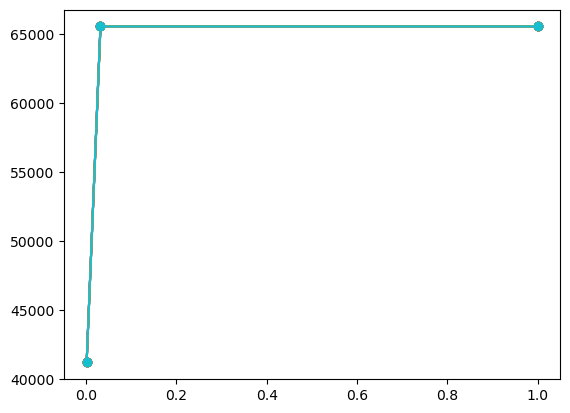

In [96]:
mean_vals = np.mean(img_array, axis=(2, 3))  # Mean across frames and image dimensions
plt.plot(exp_times, mean_vals, marker='o')
plt.show()